# Employee Relocation Analysis: Capstone Project

**Company:** WXYZ,Brooklyn, NY, USA <br>
**Presented by:** <a href="https://www.linkedin.com/in/samuelnnitiwetheophilus/">Samuel Nnitiwe Theophilus</a>


## Background 

A Company's best resource and its largest costs are the people who bring creativity, productivity and ultimately profitability to a company- It's Employees. A good talent management program can improve an employer's competitiveness, but it does not ensure that the talent is located where it is most needed. 

In a situation where an Organization wishes to expand its branch to a new location, there will be a need to deploy staff. While it is possible for the Company to hire new talents, using current capable employees who are already familiar with the company structure and operations is the best decision for the organization in terms of Cost & overhead time required to staff to adapt and  handle its operations.
The Company will  need to find a way to relocate some keys employees for continued career development or to bring their knowledge to different subsidiaries or locations. These moves can be a daunting task for the company and a high-stress situation for the employee. If a relocation is not handled successfully, it threatens the employer's ability to retain the employee—and it risks losing someone the employer has devoted time and money to develop and move.


## Problem Definition

The **WXYZ Company** has been operating in --Brooklyn,New York-- for the past 5 years. This year, the board made the decision to open an office in --Coventry, England-- and would like to select some of its existing employees to fill some managerial roles at its new branch.
This Data Science project aims to compare the neighbourhoods in Brooklyn, New York (Current company location) with the neighbourhoods in Coventry(New Branch)  and **create Clusters of similar neighbourhoods**. This will help the company to:
1. Identify Employees who would have a smoother transition to the new branch(by identifying if their current residential address matches a cluster in the new location).
2. Identify Locations to consider as recommendation for employees who agree to relocate.


## Data

I will use the **Foursquare API** to explore neighborhoods in Brooklyn and Conventry. I will the explore the most common venue categories in each neighborhood, and then use this feature to group the neighborhoods into clusters.
I will convert addresses into their equivalent latitude and longitude values. 
Finally, I will use the Folium library to visualize the neighborhoods in Brooklyn, Coventry and their emerging clusters.


### Let's begin

##### 1. Import Libaries and dependencies

In [1]:
!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Four
!pip install bs4
from bs4 import BeautifulSoup # this module helps in web scrapping.
import requests  # this module helps us to download a web page
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
# import k-means from clustering stage
from sklearn.cluster import KMeans
import folium # map rendering library
import json # library to handle JSON files

Solving environment: done

# All requested packages already installed.



## Lets Load Brooklyn,New York Neighbourhood Data
we will extract the Borough & Neighbourhoods in Brooklyn,New York City from this data


In [2]:
#Download json file from link
!wget -q -O 'newyork_data.json' https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json
print('Data downloaded!')

Data downloaded!


In [3]:
#Load data
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
    
#relevant data needed is in the 'features key': a list of the neighborhoods
neighborhoods_data = newyork_data['features']

#Tranform the data into a pandas dataframe

# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
neighborhoods = pd.DataFrame(columns=column_names) 

#loop through the data and fill the dataframe
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)



    
#Select & preview Brooklyn,NY Neighborhood 
brooklyn_data = neighborhoods[neighborhoods['Borough'] == 'Brooklyn'].reset_index(drop=True)
brooklyn_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Brooklyn,Bay Ridge,40.625801,-74.030621
1,Brooklyn,Bensonhurst,40.611009,-73.995180
2,Brooklyn,Sunset Park,40.645103,-74.010316
3,Brooklyn,Greenpoint,40.730201,-73.954241
4,Brooklyn,Gravesend,40.595260,-73.973471


## Lets Also Load Coventry Neighbourhood Data
we will extract the Borough & Neighbourhoods in Coventry from <a href="https://en.wikipedia.org/wiki/CV_postcode_area">Wikipedia</a>.
We will scrap wikipedia to extract this data.


In [4]:
url ='https://en.wikipedia.org/wiki/CV_postcode_area'
html=requests.get(url).text
soup= BeautifulSoup(html, 'html.parser')
#Get table data for transformation
table=soup.find_all('table')
table_rows=table[1].find("tbody").find_all('tr')

hood_data=pd.DataFrame(columns=["PostalCode","Borough","Neighborhood"])
row_count=0

for row in table_rows:
    if row_count==0:
        pass
    else:
        
        postal_code=''
        for postal in row.find_all('th'):
            postal_code=postal.text.replace('\n','')
        
        value=''
        
        #Get second column
        value_count=0
        for td in row.find_all('td'):
            temp_value=td.text.split('\n')
            if value_count==1:
                value=temp_value
                
            value_count=value_count+1
            
        values_1=''
        ng_list=''
            
        if(len(value)>1):
            values_1=value[0].split('(')
            if(len(values_1)>1):
                values_1[1]=values_1[1].replace(')','')
                ng_list = values_1[1].split(',')

        for neighbor in ng_list:

            if (ng_list != []):
                hood=np.NAN

                if len(neighbor)>1:
                    hood=neighbor
                    hood_dict={"PostalCode":postal_code,"Borough":'Coventry',"Neighborhood":hood}
                    #print(hood_dict)
                    hood_data=hood_data.append(hood_dict,ignore_index=True)

    row_count=row_count+1
    
#Select only cells. without empty Borough
scraped_hood_data=hood_data[hood_data['Borough']!='']
scraped_hood_data

,PostalCode,Borough,Neighborhood
0,CV1,Coventry,Coventry City Centre
1,CV1,Coventry,Gosford Green
2,CV1,Coventry,Hillfields
3,CV1,Coventry,Spon End
4,CV1,Coventry,Coventry University
...,...,...,...
85,CV31,Coventry,Whitnash
86,CV31,Coventry,Radford Semele
87,CV32,Coventry,north
88,CV32,Coventry,Cubbington


In [5]:
#Define Functions to get latitude and longitude of Coventry
def get_lat_( address):
    try:
        geolocator = Nominatim(user_agent="ny_explorer")
        location = geolocator.geocode('{},Coventry, England'.format(address))
        latitude = location.latitude
        return latitude
    except:
        return np.NAN

def get_long_( address):
    try:
        geolocator = Nominatim(user_agent="ny_explorer")
        location = geolocator.geocode('{},Coventry, England'.format(address))
        longitude = location.longitude
        return longitude
    except:
        return np.NAN
    
#Get Longitutde
scraped_hood_data['Longitude']=scraped_hood_data['PostalCode'].apply(get_long_)

#Get Latitutde
scraped_hood_data['Latitude']=scraped_hood_data['PostalCode'].apply(get_lat_)
coventry_data=scraped_hood_data.copy()
coventry_data.head()

,PostalCode,Borough,Neighborhood,Longitude,Latitude
0,CV1,Coventry,Coventry City Centre,-1.522541,52.406551
1,CV1,Coventry,Gosford Green,-1.522541,52.406551
2,CV1,Coventry,Hillfields,-1.522541,52.406551
3,CV1,Coventry,Spon End,-1.522541,52.406551
4,CV1,Coventry,Coventry University,-1.522541,52.406551


## Drop nan values and display data for both tables

In [6]:
coventry_data= coventry_data.dropna()
#drop Postal Code column (Since we now have LAtitude and Longtitude)
coventry_data.drop('PostalCode', inplace=True, axis=1)
print(coventry_data.shape)

(86, 4)


In [7]:
brooklyn_data= brooklyn_data.dropna()
print(brooklyn_data.shape)

(70, 4)


Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

#### Define Foursquare Credentials and Version

In [8]:
CLIENT_ID = 'AMUFN4FY41EZZ5UYECMLGH4Z4ZVP4HOCJTIS5I3DTEADCZFO' # your Foursquare ID
CLIENT_SECRET = 'DQWYPQAC5MXPXAG5JGHG4PEOBZVTPMDISRFWGD00PNBZTEPO' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: AMUFN4FY41EZZ5UYECMLGH4Z4ZVP4HOCJTIS5I3DTEADCZFO
CLIENT_SECRET:DQWYPQAC5MXPXAG5JGHG4PEOBZVTPMDISRFWGD00PNBZTEPO


Now, let's get the top 100 venues for **Brooklyn & Coventry** that are in Marble Hill within a radius of 500 meters.
First, let's create the GET request URL. Name the URL by defining a function to handle this.

In [9]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### Get Brooklyn Venues

In [10]:
# type your answer here
brooklyn_venues = getNearbyVenues(names=brooklyn_data['Neighborhood'],
                                   latitudes=brooklyn_data['Latitude'],
                                   longitudes=brooklyn_data['Longitude']
                                  )

Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker Heights
Gerritsen Beach
Marine Park
Clinton Hill
Sea Gate
Downtown
Boerum Hill
Prospect Lefferts Gardens
Ocean Hill
City Line
Bergen Beach
Midwood
Prospect Park South
Georgetown
East Williamsburg
North Side
South Side
Ocean Parkway
Fort Hamilton
Ditmas Park
Wingate
Rugby
Remsen Village
New Lots
Paerdegat Basin
Mill Basin
Fulton Ferry
Vinegar Hill
Weeksville
Broadway Junction
Dumbo
Homecrest
Highland Park
Madison
Erasmus


In [11]:
brooklyn_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bay Ridge,40.625801,-74.030621,Pilo Arts Day Spa and Salon,40.624748,-74.030591,Spa
1,Bay Ridge,40.625801,-74.030621,Bagel Boy,40.627896,-74.029335,Bagel Shop
2,Bay Ridge,40.625801,-74.030621,Leo's Casa Calamari,40.624200,-74.030931,Pizza Place
3,Bay Ridge,40.625801,-74.030621,Pegasus Cafe,40.623168,-74.031186,Breakfast Spot
4,Bay Ridge,40.625801,-74.030621,Cocoa Grinder,40.623967,-74.030863,Juice Bar


### Get Coventry Venues

In [12]:
# type your answer here
coventry_venues = getNearbyVenues(names=coventry_data['Neighborhood'],
                                   latitudes=coventry_data['Latitude'],
                                   longitudes=coventry_data['Longitude']
                                  )

Coventry City Centre
 Gosford Green
 Hillfields
 Spon End
 Coventry University
Walsgrave
 Wyken
 Stoke
 Bell Green
 Wood End
 Potters Green
 Aldermans Green
 Clifford Park
 Woodway Park
Binley
 Whitley
 Willenhall
 Cheylesmore
 Styvechale
 Finham
 Fenside
 Stoke Aldermoor
 Green Lane
 Ernesford Grange
 Binley Woods
Tile Hill
 Canley
 Cannon Park
 Lime Tree Park
 Gibbet Hill
 Westwood Heath
 University of Warwick
Allesley
 Allesley Park
 Allesley Green
 Earlsdon
 Eastern Green
 Whoberley
 Chapelfields
 Mount Nod
 Brownshill Green
Holbrooks
 Coundon
 Radford
 Longford
 Rowley's Green
 Courthouse Green
 Whitmore Park
 Hawkesbury
Weddington
 Stockingford
 Camp Hill
 Galley Common
 Grove Farm
 Whittleford
 Chapel End
 Bermuda Village
 Caldecote
 Fenny Drayton
 Hartshill
 Ansley
 Astley
 Oldbury
 Ridge Lane
town centre
 Abbey Green
 St Nicolas Park
 Horeston Grange
 Attleborough
 Whitestone
 Hill Top
 Chilvers Coton
 Caldwell
 Burton Hastings
 Bramcote
except Exhall and Ash Green
 Bulkington

In [13]:
coventry_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Coventry City Centre,52.406551,-1.522541,Aqua,52.404729,-1.520987,Middle Eastern Restaurant
1,Coventry City Centre,52.406551,-1.522541,Blue Orchid Thai Restaurant,52.404940,-1.520638,Thai Restaurant
2,Coventry City Centre,52.406551,-1.522541,PureGym,52.408093,-1.518318,Gym / Fitness Center
3,Coventry City Centre,52.406551,-1.522541,Broomfield Tavern,52.407564,-1.526971,Pub
4,Coventry City Centre,52.406551,-1.522541,The Old Windmill,52.408293,-1.517811,Pub


## Analyze Each Neighborhood (Both Booklyn & Coventry)

Start with Brooklyn

In [14]:
# one hot encoding
brooklyn_onehot = pd.get_dummies(brooklyn_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
brooklyn_onehot['Neighborhood'] = brooklyn_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [brooklyn_onehot.columns[-1]] + list(brooklyn_onehot.columns[:-1])
brooklyn_onehot = brooklyn_onehot[fixed_columns]

#Group rows by neighborhoods by taking the mean of 
#the frequency of occurrence of each category
brooklyn_grouped = brooklyn_onehot.groupby('Neighborhood').mean().reset_index()
brooklyn_grouped.head()

,Neighborhood,Yoga Studio,Accessories Store,Airport Terminal,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,Bath Beach,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.019608,0.019608,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0
1,Bay Ridge,0.012346,0.0,0.0,0.037037,0.0,0.0,0.0,0.0,0.0,...,0.0,0.012346,0.000000,0.012346,0.0,0.0,0.000000,0.000000,0.0,0.0
2,Bedford Stuyvesant,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.032258,0.032258,0.0,0.0
3,Bensonhurst,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0
4,Bergen Beach,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0


Next we transform the venues in Coventry:

In [15]:
# one hot encoding
coventry_onehot = pd.get_dummies(coventry_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
coventry_onehot['Neighborhood'] = coventry_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [coventry_onehot.columns[-1]] + list(coventry_onehot.columns[:-1])
coventry_onehot = coventry_onehot[fixed_columns]

#Group rows by neighborhoods by taking the mean of 
#the frequency of occurrence of each category
coventry_grouped = coventry_onehot.groupby('Neighborhood').mean().reset_index()
coventry_grouped.head()

,Neighborhood,Arcade,Asian Restaurant,Auto Garage,Bakery,Bar,Beer Garden,Beer Store,Bistro,Bookstore,...,Sandwich Place,Shopping Mall,Sporting Goods Shop,Stadium,Stationery Store,Supermarket,Thai Restaurant,Video Game Store,Warehouse Store,Wine Shop
0,Abbey Green,0.0,0.000000,0.023256,0.023256,0.023256,0.023256,0.000000,0.023256,0.023256,...,0.069767,0.023256,0.0,0.0,0.023256,0.023256,0.0,0.023256,0.023256,0.0
1,Aldermans Green,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.250000,0.000000,0.0,0.000000,0.000000,0.0
2,Allesley Green,0.0,0.058824,0.000000,0.000000,0.000000,0.000000,0.058824,0.000000,0.000000,...,0.058824,0.000000,0.0,0.0,0.000000,0.058824,0.0,0.000000,0.000000,0.0
3,Allesley Park,0.0,0.058824,0.000000,0.000000,0.000000,0.000000,0.058824,0.000000,0.000000,...,0.058824,0.000000,0.0,0.0,0.000000,0.058824,0.0,0.000000,0.000000,0.0
4,Ansley,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0


Let's build a function to get neighborhoods along with the top 10 most common venues in those neighbourhoods.This function will sort the venues in descending order.


In [16]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Start with Brooklyn

In [17]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
brooklyn_hoods_venues_sorted = pd.DataFrame(columns=columns)
brooklyn_hoods_venues_sorted['Neighborhood'] = brooklyn_grouped['Neighborhood']

for ind in np.arange(brooklyn_grouped.shape[0]):
    brooklyn_hoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(brooklyn_grouped.iloc[ind, :], num_top_venues)

brooklyn_hoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bath Beach,Pizza Place,Pharmacy,Chinese Restaurant,Donut Shop,Italian Restaurant,Bubble Tea Shop,Peruvian Restaurant,Gas Station,Fast Food Restaurant,Sports Bar
1,Bay Ridge,Spa,Italian Restaurant,Pizza Place,Greek Restaurant,American Restaurant,Bar,Bagel Shop,Chinese Restaurant,Café,Playground
2,Bedford Stuyvesant,Coffee Shop,Café,Pizza Place,Deli / Bodega,Bar,Gourmet Shop,Thrift / Vintage Store,Juice Bar,Community Center,Basketball Court
3,Bensonhurst,Chinese Restaurant,Italian Restaurant,Flower Shop,Donut Shop,Ice Cream Shop,Sushi Restaurant,Shabu-Shabu Restaurant,Supermarket,Spa,Smoke Shop
4,Bergen Beach,Harbor / Marina,Baseball Field,Athletics & Sports,Park,Hockey Field,Playground,Factory,Falafel Restaurant,Farm,Farmers Market


Now lets also create a sorted dataframe of Coventry's Top 10 places

In [18]:
# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
coventry_hoods_venues_sorted = pd.DataFrame(columns=columns)
coventry_hoods_venues_sorted['Neighborhood'] = coventry_grouped['Neighborhood']

for ind in np.arange(coventry_grouped.shape[0]):
    coventry_hoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(coventry_grouped.iloc[ind, :], num_top_venues)

coventry_hoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Abbey Green,Clothing Store,Furniture / Home Store,Sandwich Place,Coffee Shop,Pharmacy,Pizza Place,Pub,Museum,Nightclub,Bistro
1,Aldermans Green,Coffee Shop,Stationery Store,Pub,Wine Shop,Clothing Store,Gym / Fitness Center,Grocery Store,General Entertainment,Furniture / Home Store,Fish & Chips Shop
2,Allesley Green,Indian Restaurant,Pub,Italian Restaurant,Beer Store,Park,Persian Restaurant,Café,Sandwich Place,Restaurant,Liquor Store
3,Allesley Park,Indian Restaurant,Pub,Italian Restaurant,Beer Store,Park,Persian Restaurant,Café,Sandwich Place,Restaurant,Liquor Store
4,Ansley,Liquor Store,Pub,Wine Shop,Coffee Shop,Gym / Fitness Center,Grocery Store,General Entertainment,Furniture / Home Store,Fish & Chips Shop,Fast Food Restaurant


## Lets Visualize the Data a bit:

In [19]:
# use the inline backend to generate the plots within the browser
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot')

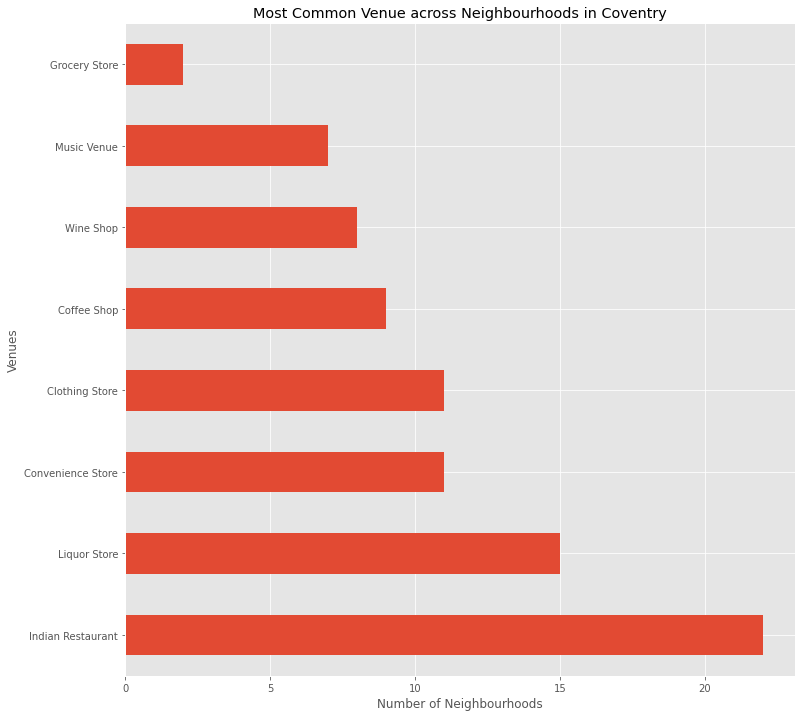

In [20]:
coventry_hoods_venues_sorted['1st Most Common Venue'].value_counts().plot(kind='barh', figsize=(12, 12))

plt.title('Most Common Venue across Neighbourhoods in Coventry')
plt.ylabel('Venues')
plt.xlabel('Number of Neighbourhoods')
plt.show()

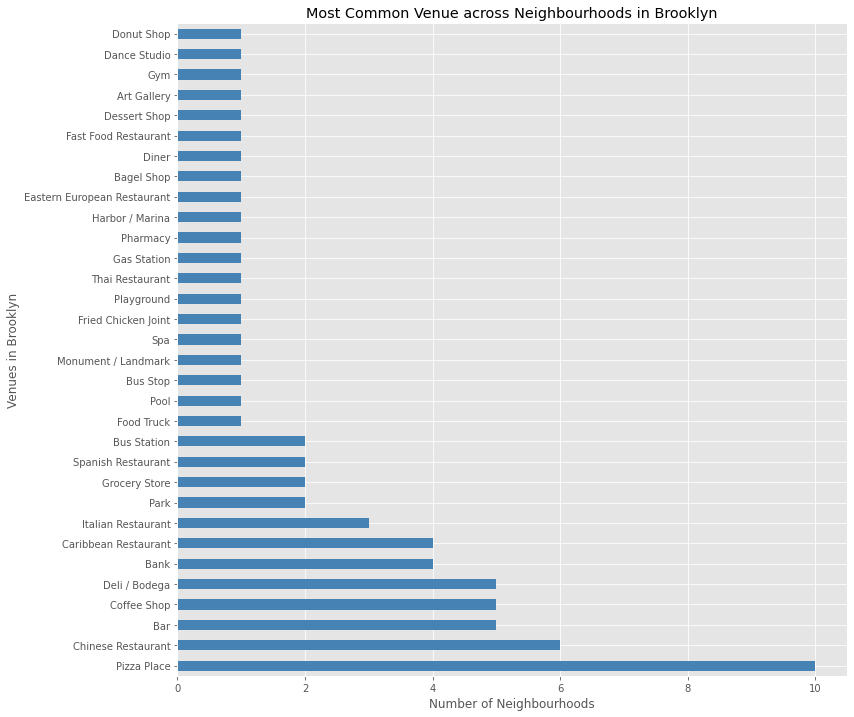

In [21]:
brooklyn_hoods_venues_sorted['1st Most Common Venue'].value_counts().plot(kind='barh', figsize=(12, 12),color='steelblue')

plt.title('Most Common Venue across Neighbourhoods in Brooklyn')
plt.ylabel('Venues in Brooklyn')
plt.xlabel('Number of Neighbourhoods')
plt.show()

## Cluster Neighborhoods
Run k-means to cluster the neighborhood into 9 clusters.

But first, lets merge the Brooklyn and Coventry Dataframes.

In [22]:
cluster_data= pd.concat([brooklyn_grouped, coventry_grouped])
cluster_data.shape

(155, 301)

In [23]:
#Fill NAN values with 0
cluster_data.fillna(0,inplace=True)
cluster_data.head()

,Neighborhood,Yoga Studio,Accessories Store,Airport Terminal,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,...,Wings Joint,Women's Store,Arcade,Auto Garage,Casino,English Restaurant,Persian Restaurant,Stadium,Stationery Store,Warehouse Store
0,Bath Beach,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Bay Ridge,0.012346,0.0,0.0,0.037037,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Bedford Stuyvesant,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bensonhurst,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Bergen Beach,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Now Create Clusters:

In [24]:
# set number of clusters
kclusters = 15

battle_grouped_clustering = cluster_data.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(battle_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([11,  3,  3,  3,  3,  3, 11,  3, 11,  3], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [25]:
#Merge venues
total_venues_sorted=pd.concat([brooklyn_hoods_venues_sorted, coventry_hoods_venues_sorted])
total_venues_sorted.fillna('',inplace=True)

#Merge Orginal Data
total_merged=pd.concat([brooklyn_data, coventry_data])
# add clustering labels
total_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)


# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
Neighbourhood_merged = total_merged.join(total_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
Neighbourhood_merged['Cluster Labels'].fillna(kclusters+1,inplace=True)
Neighbourhood_merged.fillna(0,inplace=True)
Neighbourhood_merged.head()

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Brooklyn,Bay Ridge,40.625801,-74.030621,3,Spa,Italian Restaurant,Pizza Place,Greek Restaurant,American Restaurant,Bar,Bagel Shop,Chinese Restaurant,Café,Playground
1,Brooklyn,Bensonhurst,40.611009,-73.995180,3,Chinese Restaurant,Italian Restaurant,Flower Shop,Donut Shop,Ice Cream Shop,Sushi Restaurant,Shabu-Shabu Restaurant,Supermarket,Spa,Smoke Shop
2,Brooklyn,Sunset Park,40.645103,-74.010316,11,Bank,Bakery,Pizza Place,Mexican Restaurant,Latin American Restaurant,Fried Chicken Joint,Pharmacy,Mobile Phone Shop,Gym,Grocery Store
3,Brooklyn,Greenpoint,40.730201,-73.954241,3,Bar,Coffee Shop,Pizza Place,Cocktail Bar,Grocery Store,Mexican Restaurant,Deli / Bodega,French Restaurant,Yoga Studio,Record Shop
4,Brooklyn,Gravesend,40.595260,-73.973471,11,Chinese Restaurant,Lounge,Pizza Place,Bakery,Italian Restaurant,Diner,Bus Station,Pharmacy,Donut Shop,Furniture / Home Store


In [26]:

Neighbourhood_merged.shape

(156, 15)

## Create Two Maps and View the Clusters generated
1. Brooklyn

In [33]:
# create map of New York using latitude and longitude values
latitude= 40.665535
longitude=-73.969749
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

kclusters=kclusters+1
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Neighbourhood_merged['Latitude'], Neighbourhood_merged['Longitude'], Neighbourhood_merged['Neighborhood'], Neighbourhood_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

2. Coventry

In [28]:
# create map of New York using latitude and longitude values
latitude=get_lat_('Coventry')
longitude=get_long_('Coventry')
# create map
map2_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

kclusters=kclusters+1
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Neighbourhood_merged['Latitude'], Neighbourhood_merged['Longitude'], Neighbourhood_merged['Neighborhood'], Neighbourhood_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map2_clusters)
       
map2_clusters

In [29]:
 Neighbourhood_merged['Cluster Labels'].unique()

array([ 3, 11, 14, 10, 12, 13,  6,  4,  2,  0,  8,  1,  7,  9,  5],
      dtype=int32)

## Review
Let us try and compare 2 Neighbourhoods in **Brooklyn** with 2 Neighbourhoods in **Coventry**  in the same cluster and see if they look familar.

In [79]:
Neighbourhood_merged[(Neighbourhood_merged.Borough=='Brooklyn')&(Neighbourhood_merged['Cluster Labels']==14)].head(2)

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
28,Brooklyn,Canarsie,40.635564,-73.902093,14,Deli / Bodega,Asian Restaurant,Caribbean Restaurant,Thai Restaurant,Chinese Restaurant,Gym,Discount Store,Factory,Food Court,Food & Drink Shop


In [75]:
Neighbourhood_merged[(Neighbourhood_merged.Borough=='Coventry')&(Neighbourhood_merged['Cluster Labels']==14)].head(2)

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue


In [80]:
Neighbourhood_merged.to_csv('neighbourhood.csv')